In [ ]:
import html
import math
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from datasets import Dataset, load_dataset, load_from_disk
from IPython.display import Markdown, display
from peft import LoraConfig, PeftModel, TaskType, get_peft_model, prepare_model_for_kbit_training
from sentence_transformers import InputExample, SentenceTransformer, losses, util
from sentence_transformers.trainer import SentenceTransformerTrainer
from sentence_transformers.training_args import SentenceTransformerTrainingArguments
from torch.nn import functional as F
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments,
)

In [30]:
# Глобальные переменные
rstate = 42

# Задание 1: Дообучение декодерной модели

# 1. Подготовка данных и модели

### 1.1. Выбор и загрузка датасета

Используем датасет с отзывами на фильмы с Кинопоиска.

In [31]:
dataset_name = "blinoff/kinopoisk"
local_dataset_path = "./kinopoisk_dataset_local"

if os.path.exists(local_dataset_path):
    dataset = load_from_disk(local_dataset_path)
else:
    dataset = load_dataset(dataset_name)
    dataset.save_to_disk(local_dataset_path)

### 1.2. Выбор и загрузка предобученной модели

В качестве базовой модели выберем `ai-forever/mGPT` (1.3B параметров), которая является хорошим компромиссом между размером и доступными ресурсами. 

Для дообучения будем использовать QLoRA, поэтому сразу настроим 4-битную квантизацию при загрузке.

In [ ]:
model_name = "./mGPT_local"  # локальная копию ai-forever/mGPT

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
)

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    model_name, quantization_config=bnb_config, device_map={"": 0}, trust_remote_code=True
)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

### 1.3. Предварительная обработка данных

Проанализируем распределение длин текстов, чтобы выбрать оптимальную длину контекста.

Token indices sequence length is longer than the specified maximum sequence length for this model (2375 > 2048). Running this sequence through the model will result in indexing errors


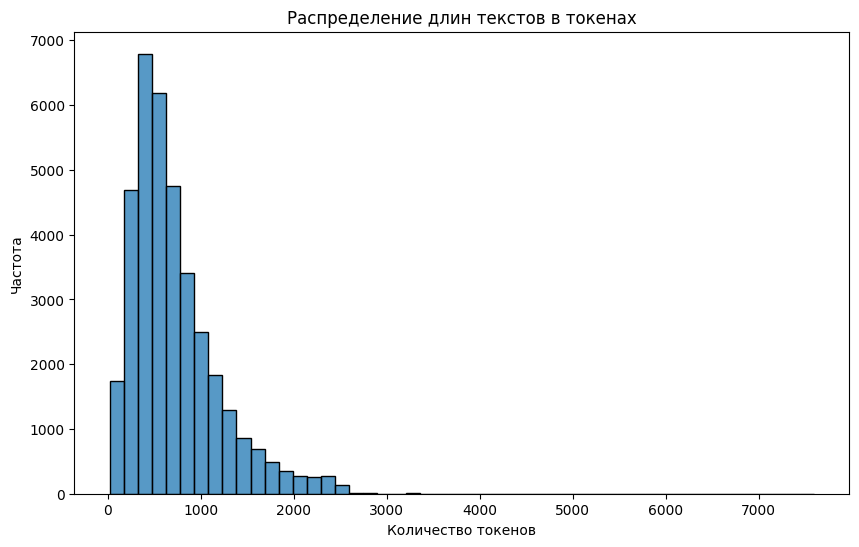

In [33]:
train_split = dataset["train"]

text_lengths = [len(tokenizer.encode(html.unescape(text))) for text in train_split["content"]]
plt.figure(figsize=(10, 6))
sns.histplot(text_lengths, bins=50)
plt.title("Распределение длин текстов в токенах")
plt.xlabel("Количество токенов")
plt.ylabel("Частота")
plt.show()

In [34]:
# Выберем сбалансированный размер, покрывающий больше половины датасета, но
# приемлимый для обучения на имеющихся вычислительной мощности
context_length = 512


def tokenize_function(examples):
    return tokenizer(
        html.unescape(examples["content"]), padding="max_length", truncation=True, max_length=context_length
    )


tokenized_dataset = train_split.map(
    tokenize_function,
    batched=True,
    remove_columns=train_split.column_names,
)

train_val_split = tokenized_dataset.train_test_split(test_size=0.1, seed=rstate)
train_dataset = train_val_split["train"]
val_dataset = train_val_split["test"]

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# 2. Предварительная оценка качества

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Функция генерации текста
def generate_text(model, tokenizer, prompt, max_length=50):
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
    output = model.generate(input_ids, max_length=max_length, num_return_sequences=1, no_repeat_ngram_size=2, top_k=50)
    return tokenizer.decode(output[0], skip_special_tokens=True)


print("--- Результат генерации ДО дообучения: ---")

prompts = ["Этот фильм был просто", "Актерская игра была на высоте, особенно", "Я не рекомендую этот фильм, потому что"]

for prompt in prompts:
    print(f"Промпт: {prompt}")
    generated_text = generate_text(model, tokenizer, prompt)
    display(Markdown(f"> {generated_text}\n"))

--- Результат генерации ДО дообучения: ---
Промпт: Этот фильм был просто


> Этот фильм был просто великолепен. Он был снят в очень хорошем качестве, и я не могу сказать, что я ожидал от него больше. Я не ожидала, чтобы он был настолько хорошим, как это было


Промпт: Актерская игра была на высоте, особенно


> Актерская игра была на высоте, особенно в роли Саши.
Спасибо за фильм, очень понравился. Спаасибки за рецензию.


Промпт: Я не рекомендую этот фильм, потому что


> Я не рекомендую этот фильм, потому что он не очень хорош.
Вот такая история. Вот такой фильм. И вот такую историю. Но, как говорится, не надо забывать, что все мы


### Оценка с помощью lm-evaluation-harness

Для оценки на стандартных бенчмарках используем `lm-evaluation-harness`. Мы запустим его для задачи `hellaswag_ru`. Эта задача оценивает возможность модели оценивать логическое продолжение предложения из промта.

In [36]:
!lm_eval --model hf \
    --model_args pretrained=./mGPT_local,trust_remote_code=True,max_length=2048,dtype="float16" \
    --tasks hellaswag_ru \
    --device cuda:0 \
    --batch_size 4 \
    --limit 4000

2025-12-25:13:41:11 WARNING  [__main__:369]  --limit SHOULD ONLY BE USED FOR TESTING.REAL METRICS SHOULD NOT BE COMPUTED USING LIMIT.
2025-12-25:13:41:11 INFO     [__main__:465] Selected Tasks: ['hellaswag_ru']
2025-12-25:13:41:11 INFO     [evaluator:202] Setting random seed to 0 | Setting numpy seed to 1234 | Setting torch manual seed to 1234 | Setting fewshot manual seed to 1234
2025-12-25:13:41:11 INFO     [evaluator:240] Initializing hf model, with arguments: {'pretrained': './mGPT_local', 'trust_remote_code': True, 'max_length': 2048, 'dtype': 'float16'}
2025-12-25:13:41:11 INFO     [models.huggingface:158] Using device 'cuda:0'
2025-12-25:13:41:11 INFO     [models.huggingface:420] Model parallel was set to False, max memory was not set, and device map was set to {'': 'cuda:0'}
2025-12-25:13:41:17 INFO     [tasks:695] Selected tasks:
2025-12-25:13:41:17 INFO     [tasks:686] Task: hellaswag_ru (okapi/hellaswag_multilingual/hellaswag_ru.yaml)
2025-12-25:13:41:17 INFO     [api.task:4

**Выводы:** базовая модель показала на тесте HellaSwag нормализованную точность 0.3295, что уверенно превышает порог случайного угадывания (0.25). Этот результат фиксируется как отправная точка для проверки того, не разрушит ли дообучение общую логику и "здравый смысл" модели.

# 3. QLoRA-дообучение

In [ ]:
# Готовим модель к обучению
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

# Конфигурация LoRA
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    # ВАЖНО: для mGPT используем c_attn
    target_modules=["c_attn"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    fan_in_fan_out=True,
)

model = get_peft_model(model, lora_config)


def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )


print_trainable_parameters(model)

trainable params: 3145728 || all params: 816762880 || trainable%: 0.38514580878112387


In [38]:
# Отключаем встроенный параллелизм токенизатора, чтобы не конфликтовал с DataLoader
os.environ["TOKENIZERS_PARALLELISM"] = "false"

training_args = TrainingArguments(
    output_dir="./mgpt_kinopoisk_generator",
    # --- Ограничение времени обучения ---
    # Для задачи адаптации стиля возьмем умеренное количество шагов:
    max_steps=1000,
    # --- Стратегия сохранения и оценки ---
    # Так как мы не покрываем полную эпоху, то будем оценивать качество и сохранять чекпоинт
    # каждые 200 шагов. Всего будем хранить не более 2 чекпоинтов, чтобы иметь возможность выбрать лучший.
    eval_strategy="steps",
    eval_steps=200,
    save_strategy="steps",
    save_steps=200,
    save_total_limit=2,
    load_best_model_at_end=True,
    # --- Параметры оптимизации ---
    # Эмпирическая оценка. 2e-4 — "золотой стандарт" для обучения адаптеров LoRA.
    learning_rate=2e-4,
    # Снизим точность, чтобы поместиться в 8 Гб имеющейся видеопамяти
    fp16=True,
    # --- Размеры батча ---
    # Подберем размеры батчей и количество накоплений шагов градиента для максимальной утилизации вычислительной мощности
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    # --- Прочее ---
    dataloader_num_workers=4,
    logging_dir="./logs",
    logging_steps=50,
    report_to="none",
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant": False},
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    processing_class=tokenizer,
    data_collator=data_collator,
)

print("Начинаем дообучение модели...")
trainer.train()
print("Дообучение завершено.")

Начинаем дообучение модели...


Step,Training Loss,Validation Loss
200,2.514700,2.425513
400,2.485100,2.385436
600,2.453100,2.368608
800,2.447300,2.359834
1000,2.437600,2.356457


Дообучение завершено.


## Сохранение дообученной модели

In [39]:
# 1. Сохраняем веса LoRA и токенизатор
adapter_path = "./mgpt_kinopoisk_lora_adapters"
trainer.save_model(adapter_path)
tokenizer.save_pretrained(adapter_path)
print(f"Адаптеры сохранены в {adapter_path}")

# 2. Очищаем память от старой модели
del model, trainer
torch.cuda.empty_cache()

# 3. Загружаем базовую модель
base_model_name = "./mGPT_local"
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_name, torch_dtype=torch.float16, device_map="auto", trust_remote_code=True
)

# 4. Накладываем на нее ваши обученные адаптеры
adapter_path = "./mgpt_kinopoisk_generator/checkpoint-1000"
print("Загружаем адаптеры и объединяем...")
model_to_merge = PeftModel.from_pretrained(base_model, adapter_path)

# 5. Физическое слияние весов
merged_model = model_to_merge.merge_and_unload()

# 6. Сохраняем готовую модель
output_merged_dir = "./mgpt_kinopoisk_finetuned_full"
merged_model.save_pretrained(output_merged_dir)
tokenizer.save_pretrained(output_merged_dir)
print(f"Полная модель успешно сохранена в: {output_merged_dir}")

Адаптеры сохранены в ./mgpt_kinopoisk_lora_adapters


`torch_dtype` is deprecated! Use `dtype` instead!


Загружаем адаптеры и объединяем...
Полная модель успешно сохранена в: ./mgpt_kinopoisk_finetuned_full


## Загрузка дообученной модели

In [40]:
finetuned_model_path = "./mgpt_kinopoisk_finetuned_full"

print(f"Загружаю модель из {finetuned_model_path}...")

tokenizer = AutoTokenizer.from_pretrained(finetuned_model_path)
finetuned_model = AutoModelForCausalLM.from_pretrained(
    finetuned_model_path,
    dtype=torch.float16,
    device_map="auto",
)

print("Дообученная модель успешно загружена!")

Загружаю модель из ./mgpt_kinopoisk_finetuned_full...
Дообученная модель успешно загружена!


# 4. Оценка качества обучения

In [41]:
prompts = ["Этот фильм был просто", "Актерская игра была на высоте, особенно", "Я не рекомендую этот фильм, потому что"]

In [42]:
print("--- Результат генерации ПОСЛЕ дообучения: ---")


# Фунция для генерации ответа
def generate_text(model, tokenizer, prompt, max_new_tokens=50):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    output = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        num_return_sequences=1,
        no_repeat_ngram_size=2,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        temperature=0.7,
    )
    return tokenizer.decode(output[0], skip_special_tokens=True)


for prompt in prompts:
    print(f"Промпт: {prompt}")
    generated_text = generate_text(finetuned_model, tokenizer, prompt)
    display(Markdown(f"> {generated_text}\n"))

--- Результат генерации ПОСЛЕ дообучения: ---
Промпт: Этот фильм был просто


> Этот фильм был просто замечательный! Я просто в конце фильма просто замерла и когда его просмотрела, я была вам за.

У меня такая же разница в


Промпт: Актерская игра была на высоте, особенно


> Актерская игра была на высоте, особенно в «Донбассе», где потрясающие актеры играли свои роли. В «Зелёном ящике» тоже отлично сыграли.

Напоследок хочу сказать,


Промпт: Я не рекомендую этот фильм, потому что


> Я не рекомендую этот фильм, потому что в фильме есть всё своё и иже с тем, что, в помимо всего прочего, это кусочек мульта, который так же является хорошим примером того, как


### Оценка с помощью lm-evaluation-harness

Аналогично проверке базовой модеои - запустим `lm-evaluation-harness` для задачи `hellaswag_ru`.

In [43]:
!lm_eval --model hf \
    --model_args pretrained=./mgpt_kinopoisk_finetuned_full,trust_remote_code=True,max_length=2048,dtype="float16" \
    --tasks hellaswag_ru \
    --device cuda:0 \
    --batch_size 4 \
    --limit 4000

2025-12-25:16:40:42 WARNING  [__main__:369]  --limit SHOULD ONLY BE USED FOR TESTING.REAL METRICS SHOULD NOT BE COMPUTED USING LIMIT.
2025-12-25:16:40:42 INFO     [__main__:465] Selected Tasks: ['hellaswag_ru']
2025-12-25:16:40:42 INFO     [evaluator:202] Setting random seed to 0 | Setting numpy seed to 1234 | Setting torch manual seed to 1234 | Setting fewshot manual seed to 1234
2025-12-25:16:40:42 INFO     [evaluator:240] Initializing hf model, with arguments: {'pretrained': './mgpt_kinopoisk_finetuned_full', 'trust_remote_code': True, 'max_length': 2048,
        'dtype': 'float16'}
2025-12-25:16:40:42 INFO     [models.huggingface:158] Using device 'cuda:0'
2025-12-25:16:40:42 INFO     [models.huggingface:420] Model parallel was set to False, max memory was not set, and device map was set to {'': 'cuda:0'}
2025-12-25:16:40:47 INFO     [tasks:695] Selected tasks:
2025-12-25:16:40:47 INFO     [tasks:686] Task: hellaswag_ru (okapi/hellaswag_multilingual/hellaswag_ru.yaml)
2025-12-25:16

# Выводы

1. Количественная оценка (HellaSwag Ru) - для контроля общего уровня «интеллекта» модели и проверки на катастрофическое забывание использовался бенчмарк hellaswag_ru (задача на здравый смысл и продолжение текста).

    Получены результаты:
- До обучения: acc_norm = 0.3295 (±0.0074)
- После обучения: acc_norm = 0.3277 (±0.0074)

    Падение на 0.0018 близко к статистической погрешности. Модель сохранила свои общие знания и способность связно продолжать текст.

2. Качественная оценка (Генерация текста) - cравнение генерации на одних и тех же промптах показывает явный сдвиг в доменную область:

    Базовая модель: Генерировала тексты общего характера, иногда сваливаясь в повторы или теряя контекст рецензии (например, фразы «Спаасибки за рецензию»).

    Дообученная модель: Успешно переняла стилистику пользователей Кинопоиска. Однако из-за ограничений самой модели, количества вычислительных мощностей или самого QLoRA подхода к дообучению - изменения практически незаметны без вдумчивого и пословного сравнения.

# Задание 2: Дообучение энкодерной модели

## 1-2. Выбор датасета и модели

**Датасет:** `kuznetsoffandrey/sberquad` - датасет с парами "вопрос-ответ".

**Модель:** `cointegrated/rubert-tiny2`

In [44]:
encoder_dataset = load_dataset("kuznetsoffandrey/sberquad")
encoder_df = encoder_dataset["train"].to_pandas()

# Извлечем текстовые ответы и создадим новую колонку 'answer'
encoder_df["answer"] = encoder_df["answers"].apply(lambda x: x["text"][0] if len(x["text"]) > 0 else "")

# Удалим строки, где не удалось извлечь ответ
encoder_df = encoder_df[encoder_df["answer"] != ""].copy()

print(f"Загружено и обработано {len(encoder_df)} пар вопрос-ответ.")
encoder_df.head()

Загружено и обработано 45328 пар вопрос-ответ.


,id,title,context,question,answers,answer
0,62310,SberChallenge,В протерозойских отложениях органические остат...,чем представлены органические остатки?,{'text': ['известковыми выделениями сине-зелён...,известковыми выделениями сине-зелёных водорослей
1,28101,SberChallenge,В протерозойских отложениях органические остат...,что найдено в кремнистых сланцах железорудной ...,"{'text': ['нитевидные водоросли, грибные нити'...","нитевидные водоросли, грибные нити"
2,48834,SberChallenge,В протерозойских отложениях органические остат...,что встречается в протерозойских отложениях?,"{'text': ['органические остатки'], 'answer_sta...",органические остатки
3,83056,SberChallenge,В протерозойских отложениях органические остат...,что относится к числу древнейших растительных ...,{'text': ['скопления графито-углистого веществ...,скопления графито-углистого вещества
4,5816,SberChallenge,В протерозойских отложениях органические остат...,как образовалось графито-углистое вещество?,{'text': ['в результате разложения Corycium en...,в результате разложения Corycium enigmaticum


In [45]:
base_encoder_model_name = "cointegrated/rubert-tiny2"
device = "cuda" if torch.cuda.is_available() else "cpu"

# 1. Загрузим базовую модель
st_model = SentenceTransformer(base_encoder_model_name, device=device)

# Извлекаем базовый AutoModel из SentenceTransformer
backbone = st_model[0].auto_model

# Включаем gradient checkpointing
if hasattr(backbone, "gradient_checkpointing_enable"):
    backbone.gradient_checkpointing_enable()

# 2. Конфигурация LoRA
lora_cfg = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
    target_modules=["query", "value"],
    task_type=TaskType.FEATURE_EXTRACTION,
)

# Применяем LoRA к backbone модели
peft_backbone = get_peft_model(backbone, lora_cfg)
peft_backbone.print_trainable_parameters()

# 3. Заменяем оригинальный backbone на PEFT-обернутый
st_model[0].auto_model = peft_backbone

# Токенизатор SentenceTransformer будет работать с PEFT-моделью
encoder_tokenizer = st_model.tokenizer

trainable params: 29,952 || all params: 29,223,720 || trainable%: 0.1025


## 3. Предварительная оценка качества

Для оценки качества будем использовать метрику **Accuracy@k**. 

**Логика:**
1. Создадим тестовую выборку из 1000 примеров.
2. Вопросы (`queries`) и ответы (`corpus`) из этой выборки будут использоваться для поиска.
3. Для каждого вопроса мы будем искать наиболее похожий на него текст в корпусе всех ответов.
4. Если правильный ответ на вопрос попадает в `k` наиболее похожих ответов из корпуса, то считаем, что модель справилась.

In [46]:
# Функция-обертка для получения эмбеддингов предложений
def get_sentence_embeddings(texts, model, batch_size=32):
    # SentenceTransformer.encode умеет работать со списками
    return model.encode(texts, convert_to_tensor=True, show_progress_bar=False, batch_size=batch_size)


eval_df = encoder_df.sample(1000, random_state=rstate)
corpus = eval_df["answer"].tolist()
queries = eval_df["question"].tolist()
relevant_docs = {queries[i]: {corpus[i]} for i in range(len(queries))}


def evaluate_model(model, queries, corpus, relevant_docs, k_values=[1, 3, 5]):
    results = {}
    for k in k_values:
        results[f"accuracy@{k}"] = 0

    corpus_embeddings = get_sentence_embeddings(corpus, model)

    for i, query in enumerate(tqdm(queries)):
        query_embedding = get_sentence_embeddings(query, model)
        cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
        top_results = torch.topk(cos_scores, k=max(k_values))

        for k in k_values:
            top_k_indices = top_results.indices[:k]
            top_k_docs = [corpus[idx.item()] for idx in top_k_indices]
            if relevant_docs[query].intersection(set(top_k_docs)):
                results[f"accuracy@{k}"] += 1

    for k in k_values:
        results[f"accuracy@{k}"] = np.round(results[f"accuracy@{k}"] / len(queries), 4)

    return results


print("--- Оценка базовой модели ---")
base_model_results = evaluate_model(st_model, queries, corpus, relevant_docs)
print(base_model_results)

--- Оценка базовой модели ---


  0%|          | 0/1000 [00:00<?, ?it/s]

{'accuracy@1': np.float64(0.09), 'accuracy@3': np.float64(0.143), 'accuracy@5': np.float64(0.177)}


# 3. QLoRA-дообучение

In [47]:
# 1. Подготовка данных
train_df = encoder_df.drop(eval_df.index)

train_examples = []
for i, row in train_df.iterrows():
    train_examples.append(InputExample(texts=[row["question"], row["answer"]]))

train_ds = Dataset.from_list([{"anchor": ex.texts[0], "positive": ex.texts[1]} for ex in train_examples])

val_examples = []
for i, row in eval_df.iterrows():  # eval_df used for validation here, as in the example
    val_examples.append(InputExample(texts=[row["question"], row["answer"]]))

val_ds = Dataset.from_list([{"anchor": ex.texts[0], "positive": ex.texts[1]} for ex in val_examples])


# 2. Настройка обучения
epochs = 5
batch_size = 32  # Модель небольшая, возьмем увеличенный размер батча
max_steps_cap = 120

steps_per_epoch = min(math.ceil(len(train_ds) / batch_size), max_steps_cap)
total_steps = steps_per_epoch * epochs

train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
train_loss = losses.MultipleNegativesRankingLoss(model=st_model)

training_args = SentenceTransformerTrainingArguments(
    output_dir="./rubert-tiny2-qa-lora-finetuned",
    # Эмуляция большого батча (32 * 4 = 128) для улучшения качества
    # contrastive loss (MNRL) и экономии видеопамяти
    per_device_train_batch_size=batch_size,  # 32
    gradient_accumulation_steps=4,
    # --- Параметры оптимизации ---
    learning_rate=2e-4,  # Эмпирическая оценка. 2e-4 — "золотой стандарт" для обучения адаптеров LoRA.
    lr_scheduler_type="cosine",  # Плавное затухание для стабильности
    warmup_ratio=0.05,  # Эмпирическая оценка. Для стабидизации обучения на начальном этапе.
    weight_decay=0.01,  # Эмпирическая оценка. Для регуляризации весов модели.
    logging_steps=50,
    num_train_epochs=epochs,
    max_steps=total_steps,
    # --- Параметры сохранения ---
    # Сохраняем только итоговую модель
    save_strategy="no",
    eval_strategy="steps",
    eval_steps=50,
    report_to="none",
    # --- Вычислительная оптимизация ---
    # Оптимизатор с выгрузкой в RAM
    optim="paged_adamw_8bit",
    # Смешанная точность (fp16) и чекпоинтинг для экономии памяти
    fp16=torch.cuda.is_available(),
    gradient_checkpointing=True,
    # Отбрасываем неполный последний батч, чтобы избежать ошибок размерности
    dataloader_drop_last=True,
    dataloader_num_workers=0,
    seed=rstate,
)

trainer = SentenceTransformerTrainer(
    model=st_model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    loss=train_loss,
)

print("Начинаем QLoRA-дообучение энкодера...")
trainer.train()
print("Дообучение завершено.")

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Начинаем QLoRA-дообучение энкодера...


Step,Training Loss,Validation Loss
50,2.604700,1.159778
100,2.081700,0.805560
150,1.821600,0.716683
200,1.703300,0.680696
250,1.615800,0.658630
300,1.632900,0.642534
350,1.591500,0.633162
400,1.531800,0.628152
450,1.567400,0.623049
500,1.574300,0.621184


Дообучение завершено.


## 5. Оценка качества обучения

In [48]:
# 1. Загружаем дообученную модель
finetuned_model_path = "./rubert-tiny2-qa-finetuned"
print(f"Загружаем дообученную модель из {finetuned_model_path}...")
finetuned_encoder_model = SentenceTransformer(finetuned_model_path)

# 2. Оцениваем качество
print("--- Оценка дообученной модели ---")
# Используем ту же функцию evaluate_model, что и для базовой модели
finetuned_model_results = evaluate_model(finetuned_encoder_model, queries, corpus, relevant_docs)
print(finetuned_model_results)

Загружаем дообученную модель из ./rubert-tiny2-qa-finetuned...
--- Оценка дообученной модели ---


  0%|          | 0/1000 [00:00<?, ?it/s]

{'accuracy@1': np.float64(0.251), 'accuracy@3': np.float64(0.389), 'accuracy@5': np.float64(0.462)}


# Выводы

Сравним результаты до и после дообучения:

**Базовая модель:**
```
{'accuracy@1': np.float64(0.09), 'accuracy@3': np.float64(0.143), 'accuracy@5': np.float64(0.177)}
```
**Дообученная модель:**
```
{'accuracy@1': np.float64(0.251), 'accuracy@3': np.float64(0.389), 'accuracy@5': np.float64(0.462)}
```
**Заключение:**
Метрики `accuracy@k` показывают, что модель стала значительно лучше сопоставлять семантическую близость вопросов и ответов. Это подтверждает, что метод дообучения QLoRA является эффективной техникой для адаптации энкодерных моделей к домен-специфичным задачам поиска, обеспечивая при этом экономию ресурсов.